<a href="https://colab.research.google.com/github/sergiorolnic/datascience/blob/main/datascience_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Box Office Prediction
**Programmazione di Applicazioni Data Intensive**

Ingegneria e Scienze Informatiche 2021

Sergiu Gabriel Rolnic

Il seguente progetto riguarda l'analisi  dei dati raccolti dal sito [The Movie Database](https://www.themoviedb.org/). Lo scopo finale sarà quello di prevedere gli incassi di un film avendo a disposizione solo dati esistenti prima della effettiva uscita nelle sale.


# **Analisi dei Dati**

Importazione del dataset e delle librerie utili per la sua analisi

In [110]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
if not os.path.exists("train.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/sergiorolnic/datascience/main/train.csv", "train.csv")

data = pd.read_csv("train.csv")    

In [112]:
data.shape

(3000, 23)

In [113]:
data.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


In [114]:
data.tail(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2999,3000,NaN,35000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",http://www.abductionthefilm.com/,tt1600195,en,Abduction,A young man sets out to uncover the truth abou...,10.512109,/cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg,"[{'name': 'Lions Gate Films', 'id': 35}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",9/22/11,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They stole his life. He's taking it back.,Abduction,"[{'id': 591, 'name': 'cia'}, {'id': 822, 'name...","[{'cast_id': 2, 'character': 'Nathan Harper', ...","[{'credit_id': '5391990d0e0a260fb5001629', 'de...",82087155


Notiamo la presenza di feature particolari: dizionari con una o piu' entrate, valori numerici su scale diverse, stringhe di varia natura. La challenge principale sarà quella di riuscire ad estrarre delle informazione utili da piu' variabili possibili.   

La colonna "id" può essere usata come indice del nostro dataframe

In [115]:
data = pd.read_csv("train.csv", index_col=0)  

In [116]:
data.head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


## Gestione Features



*   *belongs_to_collection*: appartenenza ad una serie cinematografica
*   *budget*: costo di produzione
*   *genres*: generi
*   *homepage*: link al sito web


*   *imdb_id*: id imbd

*   *original_language*: lingua originale

*   *original_title*: titolo originale

*   *overview*: plot
*   *popularity*: popolarità
*   *poster_path*: path della locandina ufficiale
*   *production_companies*: compagnia di produzione
*   *production_countries*: paese di produzione
*   *release_date*: data di uscita
*   *runtime*: durata
*   *spoken_languages*: lingua del film
*   *status*: stato del rilascio
*   *tagline*: slogan film
*   *title*: titolo
*   *Keywords*: parole chiavi
*   *cast*: cast
*   *crew*: trop
*   *revenue*: incasso del film --> variabile da predire

In [117]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  604 non-null    object 
 1   budget                 3000 non-null   int64  
 2   genres                 2993 non-null   object 
 3   homepage               946 non-null    object 
 4   imdb_id                3000 non-null   object 
 5   original_language      3000 non-null   object 
 6   original_title         3000 non-null   object 
 7   overview               2992 non-null   object 
 8   popularity             3000 non-null   float64
 9   poster_path            2999 non-null   object 
 10  production_companies   2844 non-null   object 
 11  production_countries   2945 non-null   object 
 12  release_date           3000 non-null   object 
 13  runtime                2998 non-null   float64
 14  spoken_languages       2980 non-null   object 
 15  stat

In [118]:
data.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


Verifichiamo la presenza di valori null


In [119]:
data.isnull().sum()

belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

Analizziamo le features individualmente ed eventualmente evidenziamo eventuali rapporti tra esse o con la target feature

 Notiamo che **Belongs_to_collection** e **Homepage** presentano una preponderanza di valori null. Si decide perciò di binarizzarle attraverso il quesito "Is Present?" in quanto sono features che potrebbero risultare particolarmente utili durante l'addestramento.

In [120]:
data['belongs_to_a_collection'] = data['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)
data = data.drop(columns='belongs_to_collection')

data['homepage_is_present'] = data['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
data = data.drop(columns='homepage')



**Budget**



In [130]:
data.budget

id
1       14000000
2       40000000
3        3300000
4        1200000
5              0
          ...   
2996           0
2997           0
2998    65000000
2999    42000000
3000    35000000
Name: budget, Length: 3000, dtype: int64

In [149]:
data[data.budget>1000000].budget.sort_values()

id
1777      1070000
2762      1089360
2008      1114000
1190      1119000
2993      1135654
          ...    
1271    260000000
1426    270000000
2771    280000000
2210    300000000
2136    380000000
Name: budget, Length: 2012, dtype: int64

In [121]:
data.budget[data.budget== 0] = data.budget[data.budget>]

**Budget** è l'unica feature che presenta delle caratteristiche simili alla variabile target **revenue**, perciò si decide di verificare un'eventuale correlazione tra le due

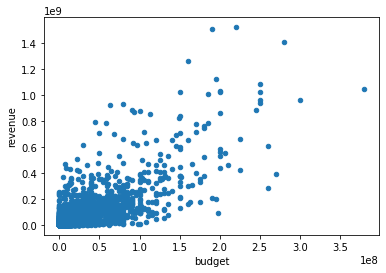

In [122]:
data.plot.scatter("budget", "revenue",);

In [123]:
np.mean((data.budget-data.budget.mean()) * (data.revenue-data.revenue.mean())) / (data.budget.std() * data.revenue.std())

0.7527135222113918

In [124]:
np.mean((np.log1p(data.budget)-np.log1p(data.budget).mean()) * (np.log1p(data.revenue)-np.log1p(data.revenue).mean())) / (np.log1p(data.budget).std() * np.log1p(data.revenue).std())

0.4980178346810494

In [125]:
data.revenue

id
1        12314651
2        95149435
3        13092000
4        16000000
5         3923970
          ...    
2996      1596687
2997       180590
2998     89456761
2999    171963386
3000     82087155
Name: revenue, Length: 3000, dtype: int64

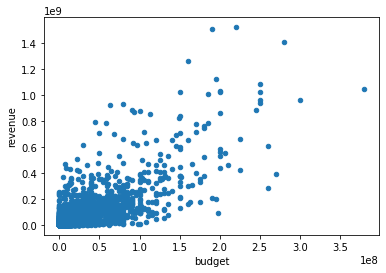

In [126]:
#data.budget = np.log1p(data.budget)
#data.revenue = np.log1p(data.revenue)

data.plot.scatter("budget", "revenue");

Usando la correlazione di Pearson si ottiene una correlazione modesta tra le due variabili

**Genres**

In [127]:
train_data["genres"] = (train_data['genres'].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)


NameError: ignored

In [ ]:
list_of_genres = {i for x in train_data.genres for i in x}

In [ ]:
for genre in list_of_genres:
  train_data["genre_" + genre] = train_data['genres'].apply(lambda x: 1 if genre in x else 0)
train_data.drop(columns='genres',inplace=True)  

Per quanto riguara le features **imdb_id, 'original_title', 'status', 'poster_path'** e **title** di eliminarle in quanto poco significative

In [ ]:
train_data.head(1)

In [ ]:
train_data.drop(columns=['imdb_id','original_title','status','poster_path', 'title'], inplace=True)

In [ ]:
train_data.dtypes

**Original_language**



In [ ]:
train_data.original_language.value_counts(normalize=True).head(5).plot.pie()


Per quanto a primo impatto potesse risultare un dato interessante, la maggior parte dei film sono in inglese, quindi risulterebbero inutili in fase di addestramento. Lo stesso ragionamento vale per **spoken_language**
Un discorso diverso invece va fatto con **popularity**. Non avendo certezza del fatto che il rating di popolarità sia antecedente alla fuoriuscita dei film, si decide cancellare la colonna assieme alle altre.

In [ ]:
train_data.drop(columns= ['original_language','spoken_languages'], inplace=True)

**Keywords**

Keywords permette di determinare delle parole chiavi da associare ad ogni film, e perciò svolge lo stesso ruole di **tagline** e **overview**

In [ ]:
train_data.drop(columns=['overview', 'tagline'], inplace=True)


In [ ]:
train_data.head(1)

In [ ]:
def cut_and_binariezed(feature):
  train_data[feature] = (train_data[feature].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)
  all_values = pd.DataFrame([i for x in train_data[feature] for i in x])
  
  split = all_values.value_counts()[:100]
  for keys in split.index:
      train_data[feature+" (" + keys[0]+ ")"] = train_data[feature].apply(lambda x: 1 if keys[0] in x else 0)
  train_data.drop(columns=feature,inplace=True) 


In [ ]:
cut_and_binariezed("Keywords")

Analogamente si procede allo stesso modo con **cast**,**crew**,  **production_companies** e **production_countries**

In [ ]:
train_data.head(1)

In [ ]:
cut_and_binariezed("production_companies")

In [ ]:
cut_and_binariezed("production_countries")

In [ ]:
cut_and_binariezed("cast")

In [ ]:
cut_and_binariezed("crew")

**Release Date**

In [ ]:
train_data.release_date.shape

In [ ]:
train_data[['release_month', 'release_day', 'release_year']] = train_data['release_date'].str.split('/', expand=True).astype(int)

In [ ]:
train_data["release_year"]=train_data['release_year'].map(lambda x: 2000 + x if x < 20 else (x+1900 if x<100 else x))

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1).bar(train_data.release_month.value_counts().index,train_data.release_month.value_counts().values)
plt.subplot(1, 3, 2).bar(train_data.release_day.value_counts().index,train_data.release_day.value_counts().values)
plt.subplot(1, 3, 3).bar(train_data.release_year.value_counts().index,train_data.release_year.value_counts().values)


In [ ]:
train_data.drop(columns='release_date', inplace=True)

In [ ]:
train_data.head(1)

In [ ]:
train_data.runtime.isnull().sum()

In [ ]:
train_data.plot.scatter("runtime", "revenue")

# Addestramento


In [ ]:
train_data.dropna(inplace=True)

In [ ]:
train_data.isna().sum()

In [ ]:
y_data = train_data.revenue
train_data.drop(columns='revenue', inplace=True)

In [ ]:
X = train_data

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

In [ ]:
# importo MSE e R²
from sklearn.metrics import mean_squared_error, r2_score

# definisco funzione per errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# funzione per calcolare e stampare tutte e tre
def print_eval(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=2, kernel="poly", degree=2))
])
from sklearn.model_selection import cross_validate
cv_result = cross_validate(model, X, y_data, cv=kf, return_train_score=True)
cv_result

In [ ]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)


In [ ]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(train_data, y_data):
        X_train, y_train = train_data.iloc[train_indices], y_data.iloc[train_indices]
        X_val, y_val = train_data.iloc[val_indices], y_data.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv)
        gs.fit(X_train, y_train)
        score = gs.score(X_val, y_val)
        results.append(score)
    return results

model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
grid = {
    "regr__degree": range(2, 11),
    "regr__alpha": [0.01, 0.1, 1, 10],
}
nested_cv(model, grid)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(X, y_data, test_size=1/3, random_state=42)

In [ ]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=2, kernel="poly", degree=2))
])
model.fit(X_train, y_train);

In [ ]:
model.score(X_train, y_train)

In [ ]:
print_eval(X_train, y_train, model)

In [ ]:
print_eval(X_val, y_val, model)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=6, random_state=42)
model.fit(X_train, y_train);

In [ ]:
model.score(X_train, y_train)

In [ ]:
print_eval(X_train, y_train, model)

In [ ]:
print_eval(X_val, y_val, model)

In [ ]:
model.score(X_val, y_val)

In [ ]:
model = DecisionTreeRegressor(min_samples_split=0.4, random_state=42)
model.fit(X_train, y_train);

In [ ]:
model.score(X_train, y_train)

In [ ]:
model.score(X_val, y_val)

In [ ]:
model = DecisionTreeRegressor(random_state=42)
grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 0.02, 0.05, 0.1]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
gs.best_params_

In [ ]:
gs.score(X_val, y_val)

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=[4],
    activation="relu",
    solver="sgd",
    random_state=12345
)

In [ ]:
model.fit(X_train, y_train);

In [ ]:
model.score(X_val, y_val)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
model.fit(X_train, y_train, batch_size=100, epochs=5)


In [ ]:
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

In [ ]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l2(0.001), input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
model.fit(X_train, y_train, batch_size=100, epochs=50)

In [ ]:
X_train.head(1)